# Tutorials

This tutorial aims to get users familiar with different functions for **GameArg**

### Import Package

In [1]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)
from lib.GameArg import *
from IPython.display import Image

## Graph Input

**Start from Win_Move Graph**

the following graph has to be a **win_move** graph, if you input a argumentation graph, please source node and target node first

In [2]:
%%file files/plain_wm_graph.dlv
edge(a,b).
edge(t,b).
edge(b,c).
edge(c,d).
edge(b,e).
edge(d,e).
edge(b,f).
edge(s,g).
edge(f,h).
edge(e,i).
edge(i,j).
edge(i,k).
edge(i,l).
edge(e,m).
edge(o,m).
edge(n,m).
edge(j,n).
edge(i,o).
edge(m,o).
edge(g,q).
edge(h,q).
edge(c,q).
edge(e,s).
edge(f,s).
edge(s,t).
edge(t,u).
edge(b,v).
edge(u,v).
edge(b,w).
edge(d,x).
edge(b,y).
edge(c,z).

Overwriting files/plain_wm_graph.dlv


## Graph Generation

**Win-Move Graph**

In [3]:
create_plain_graph("files/plain_wm_graph.dlv", "edge", "graphs/wm_graph.dot")

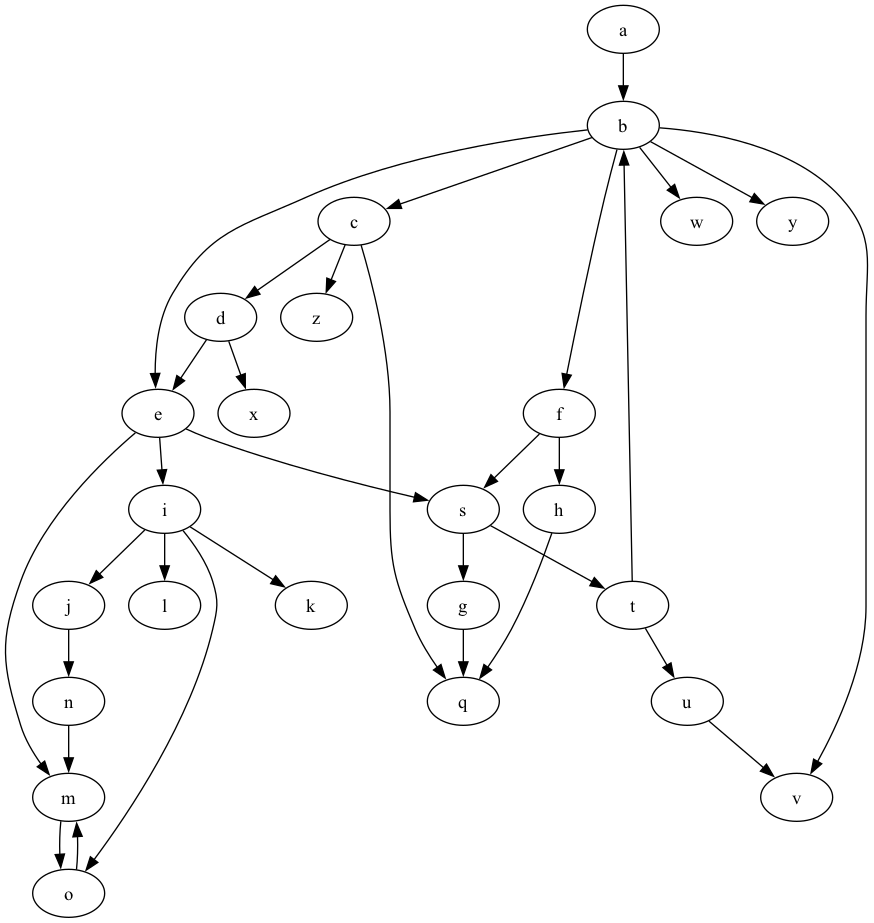

In [4]:
render_dot_to_png("graphs/wm_graph.dot", "graphs/wm_graph.png")
Image("graphs/wm_graph.png")

**Attack_Graph**

In [5]:
create_plain_graph(
    "files/plain_wm_graph.dlv", "edge", "graphs/attack_graph.dot", arg=True
)

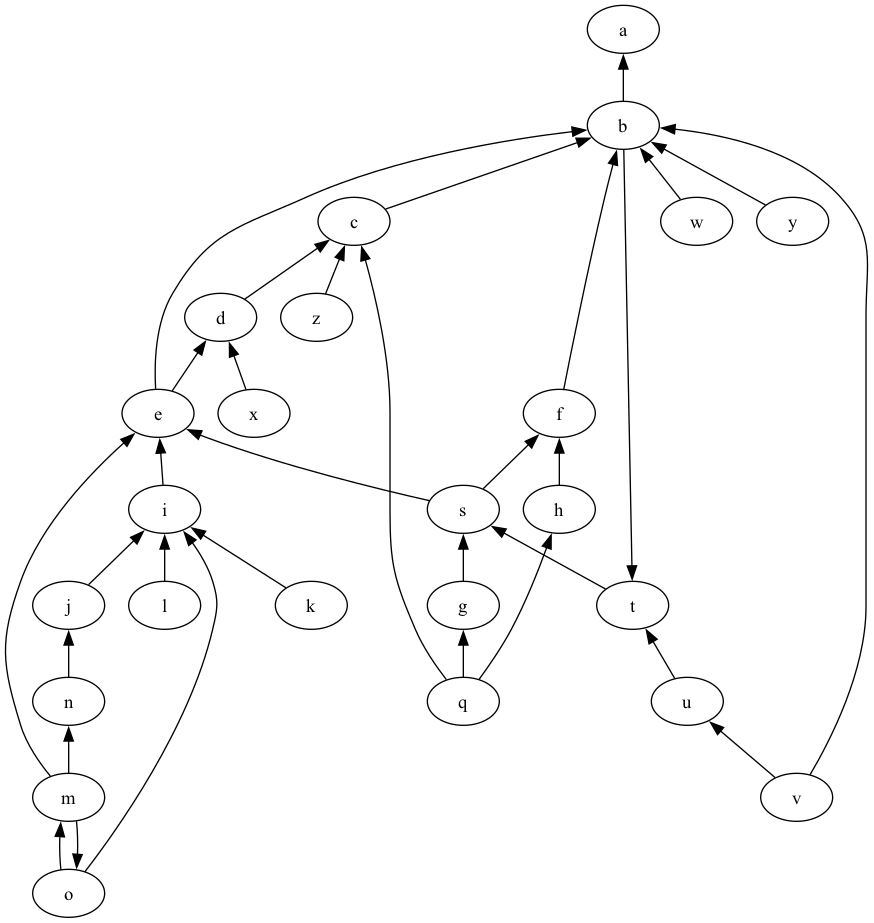

In [6]:
render_dot_to_png("graphs/attack_graph.dot", "graphs/attack_graph.png")
Image("graphs/attack_graph.png")

## Graph Coloring : Well-Founded Semantics

Here we will use the kernel as an example to help you better understand the tool

### Step by Step

#### Get Node Status

Because `e(X,Y) :- edge(X,Y).`, the graph for kernel calculation will be the same as the plain win-move graph we have drawn previously.

In [7]:
%%file files/plain_to_kernel.dlv

e(X,Y):- edge(Y,X).

Overwriting files/plain_to_kernel.dlv


Based on Combinatorial Game Theory Foundations Applied to Digraph Kernels by Dr.Fraenkel, we know that Kernel is both indepedent and dominating, which can be defined as

In [8]:
%%file files/cal_kernel.dlv

% c represents complements of kernels
% k stands for kernel
% pk means possibly in or out of kernel

% Positions
pos(X) :- e(X,_).
pos(X) :- e(_,X).

% Kernel rules
c(X) :- e(Y,X), k(Y).         % X is in the kernel complement if there is an edge from X into the kernel (to Y)
k(X) :- pos(X), not c(X).
pk(X) :- pos(X), not c(X), not k(X).

Overwriting files/cal_kernel.dlv


`-wf` indicates that the dlv will use well-founded semantics

In [9]:
cmd_solve = "dlv files/plain_wm_graph.dlv files/plain_to_kernel.dlv files/cal_kernel.dlv -wf"

let's run it with DLV, we will get the following output

In [10]:
run_command(cmd_solve)

'DLV [build BEN/Dec 17 2012   gcc 4.2.1 (Apple Inc. build 5666) (dot 3)]\n\nTrue: {edge(a,b), edge(b,c), edge(b,e), edge(b,f), edge(b,v), edge(b,w), edge(b,y), edge(t,b), edge(t,u), edge(c,d), edge(c,q), edge(c,z), edge(d,e), edge(d,x), edge(e,s), edge(e,i), edge(e,m), edge(f,s), edge(f,h), edge(s,t), edge(s,g), edge(g,q), edge(h,q), edge(i,j), edge(i,k), edge(i,l), edge(i,o), edge(j,n), edge(m,o), edge(o,m), edge(n,m), edge(u,v), e(b,a), e(b,t), e(t,s), e(c,b), e(d,c), e(e,b), e(e,d), e(f,b), e(s,e), e(s,f), e(g,s), e(h,f), e(i,e), e(j,i), e(k,i), e(l,i), e(m,e), e(m,o), e(m,n), e(o,i), e(o,m), e(n,j), e(q,c), e(q,g), e(q,h), e(u,t), e(v,b), e(v,u), e(w,b), e(x,d), e(y,b), e(z,c), pos(a), pos(b), pos(t), pos(c), pos(d), pos(e), pos(f), pos(s), pos(g), pos(h), pos(i), pos(j), pos(k), pos(l), pos(m), pos(o), pos(n), pos(q), pos(u), pos(v), pos(w), pos(x), pos(y), pos(z), k(a), c(b), k(t), c(c), c(d), k(f), c(s), c(g), c(h), c(i), k(k), k(l), k(q), c(u), k(v), k(w), k(x), k(y), k(z)}\nUn

however, we need to filterout unnecessary information

In [11]:
kernel_nodes_status = get_nodes_status(
    run_command(cmd_solve), node_types=["c", "k", "pk"]
)

thus we know the status of each nodes, which we will use for further coloring the graph

In [12]:
kernel_nodes_status

{'c': ['b', 'c', 'd', 's', 'g', 'h', 'i', 'u'],
 'k': ['a', 't', 'f', 'k', 'l', 'q', 'v', 'w', 'x', 'y', 'z'],
 'pk': ['e', 'j', 'm', 'o', 'n']}

#### Visualization Schema

In [13]:
kernel_node_color_wfs = {"c": "white", "k": "black", "pk": "gray"}
kernel_edge_color_wfs = {
    ("white", "white"): "gray",
    ("white", "gray"): "gray",
    ("gray", "white"): "gray",
    ("gray", "gray"): "dark_yellow",
    ("white", "black"): "dark_gray",
    ("black", "white"): "black",
}

In [14]:
apply_color_schema(
    "graphs/wm_graph.dot",
    "kernel",
    kernel_nodes_status,
    kernel_node_color_wfs,
    kernel_edge_color_wfs
)

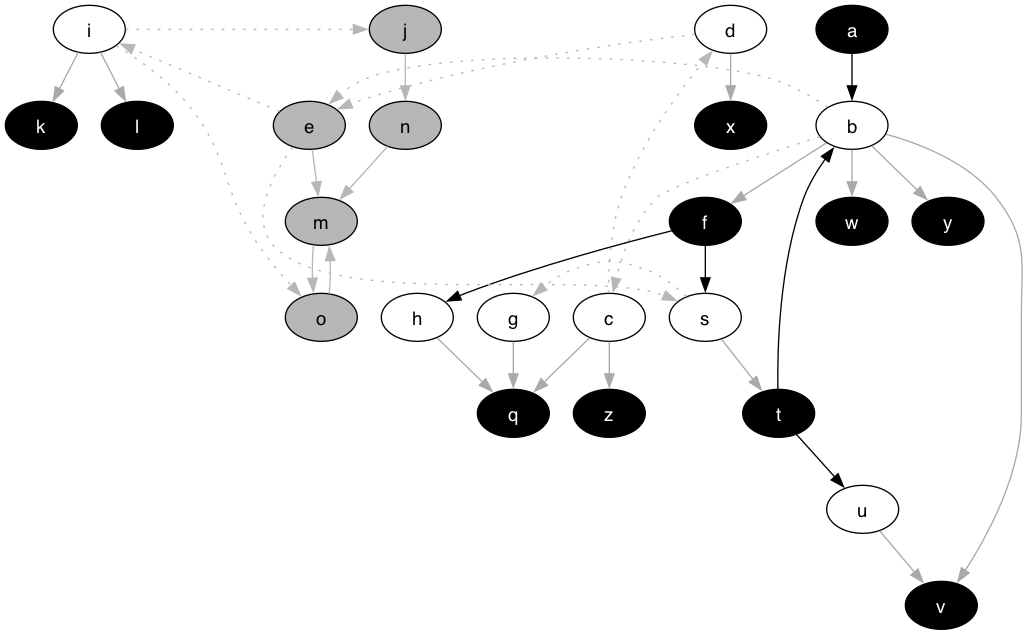

In [15]:
Image("graphs/kernel_graph_colored.png")

### One Function for All

As we have win_move graph and attack graph, we start to think about maybe we only need to provide the visualization schema and one function can provide us the expected graph

**WM game**

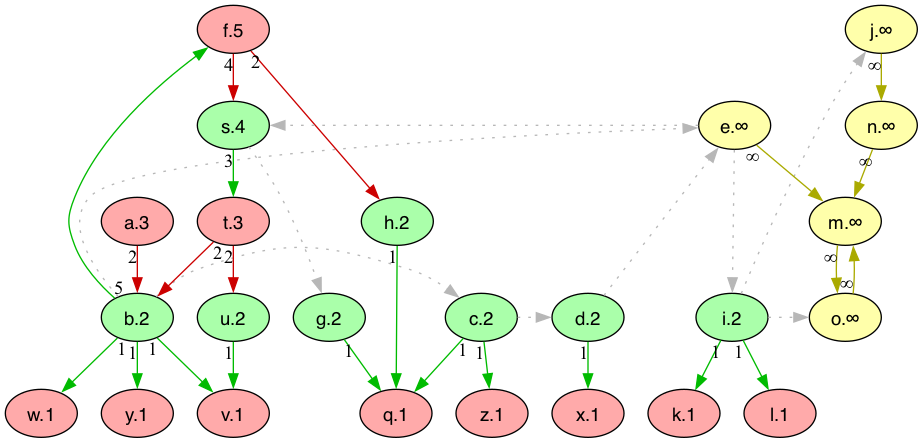

In [16]:
game_node_color_wfs = {"win": "green", "lost": "red", "drawn": "yellow"}
game_edge_color_wfs = {
    ("green", "green"): "gray",
    ("green", "yellow"): "gray",
    ("yellow", "green"): "gray",
    ("yellow", "yellow"): "yellow",
    ("green", "red"): "green",
    ("red", "green"): "red",
}
visualize_wfs(
    "files/plain_wm_graph.dlv",
    "game",
    game_node_color_wfs,
    game_edge_color_wfs,
    show_node_label=True,
    show_edge_label=True,
    rank=True
)
Image("graphs/game_graph_colored.png")

**Argumentation**

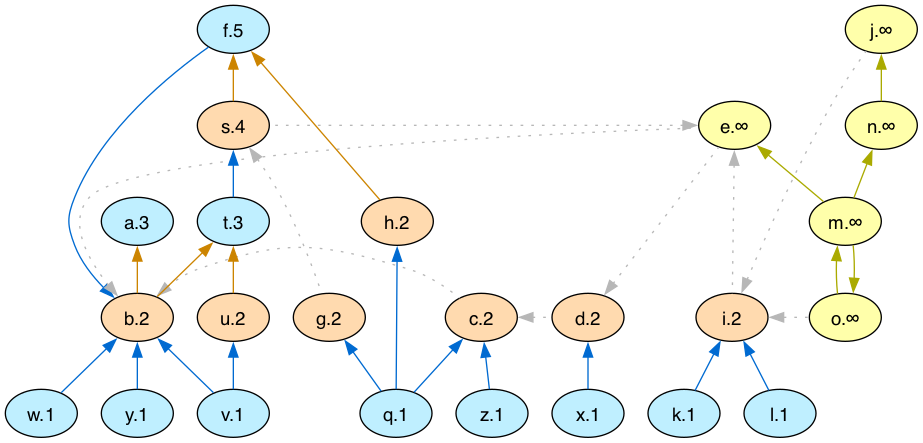

In [17]:
arg_node_color_wfs = {
    "accepted": "blue",
    "defeated": "orange",
    "undefined": "yellow",
}
arg_edge_color_wfs = {
    ("blue", "blue"): "gray",
    ("blue", "yellow"): "gray",
    ("yellow", "blue"): "gray",
    ("yellow", "yellow"): "yellow",
    ("blue", "orange"): "blue",
    ("orange", "blue"): "orange",
}
visualize_wfs(
    "files/plain_wm_graph.dlv",
    "arg",
    arg_node_color_wfs,
    arg_edge_color_wfs,
    arg=True,
    show_node_label=True,
    rank=True
)
Image("graphs/arg_graph_colored.png")

### Graph Coloring: Stable Models

#### Get Node Status

similar to the WFS, but we need to remove the solve part `-wf`

In [18]:
cmd_solve = 'dlv files/plain_wm_graph.dlv files/plain_to_kernel.dlv files/cal_kernel.dlv -filter="k"'

let's run the command

In [19]:
print(run_command(cmd_solve))

DLV [build BEN/Dec 17 2012   gcc 4.2.1 (Apple Inc. build 5666) (dot 3)]

{k(a), k(t), k(f), k(j), k(k), k(l), k(m), k(q), k(v), k(w), k(x), k(y), k(z)}

{k(a), k(t), k(e), k(f), k(k), k(l), k(o), k(n), k(q), k(v), k(w), k(x), k(y), k(z)}



After the command, we can get the possible worlds

#### One Function for All

Similar to the WFS, we also want to generate all the stable models with defined visualization schema

**Stable Models for Kernel Graph**

In [20]:
kernel_node_color_stb = {"c": "white", "k": "black"}
kernel_edge_color_stb = {
    ("white", "white"): "gray",
    ("white", "gray"): "gray",
    ("gray", "white"): "gray",
    ("gray", "gray"): "dark_yellow",
    ("white", "black"): "dark_gray",
    ("black", "white"): "black",
}
visualize_stb(
    "files/plain_wm_graph.dlv",
    "kernel",
    kernel_node_color_stb,
    kernel_edge_color_stb,
    rank=True
)

**Stable Models for WM Graph**

In [21]:
game_node_color_stb = {"win": "green", "lost": "red"}
game_edge_color_stb = {
    ("green", "green"): "gray",
    ("green", "yellow"): "gray",
    ("yellow", "green"): "gray",
    ("yellow", "yellow"): "yellow",
    ("green", "red"): "green",
    ("red", "green"): "red",
}
visualize_stb(
    "files/plain_wm_graph.dlv",
    "game",
    game_node_color_stb,
    game_edge_color_stb,
    rank=True
)

**Stable Models for Attack Graph**

In [22]:
arg_node_color_stb = {
    "accepted": "blue",
    "defeated": "orange",
    "undefined": "yellow",
}
arg_edge_color_stb = {
    ("blue", "blue"): "gray",
    ("blue", "yellow"): "gray",
    ("yellow", "blue"): "gray",
    ("yellow", "yellow"): "yellow",
    ("blue", "orange"): "blue",
    ("orange", "blue"): "orange",
}
visualize_stb(
    "files/plain_wm_graph.dlv",
    "arg",
    arg_node_color_stb,
    arg_edge_color_stb,
    arg=True,
    rank=True
)